In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, Row
from pyspark import SparkContext

In [2]:
from pyspark.sql.functions import col, struct, trim, length, lower, sha1, regexp_replace, explode, collect_list, monotonically_increasing_id
from pyspark.sql.types import StringType
from pyspark.mllib.linalg import SparseVector
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer
import random as rnd
import re
import hashlib
from tqdm import tqdm

In [3]:
spark = SparkSession \
    .builder \
    .appName("Assignment3") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/question.train") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/question.train") \
    .config("spark.jars", "file:///Users/garvita/.ivy2/jars/*") \
    .getOrCreate()

In [4]:
sc = spark.sparkContext

In [5]:
!mongoimport --type csv -d question -c train --headerline --maintainInsertionOrder --drop train.csv

2021-05-03T08:33:47.941+0530	connected to: mongodb://localhost/
2021-05-03T08:33:47.947+0530	dropping: question.train
2021-05-03T08:33:50.941+0530	[#######.................] question.train	19.1MB/60.5MB (31.6%)
2021-05-03T08:33:53.941+0530	[################........] question.train	41.2MB/60.5MB (68.2%)
2021-05-03T08:33:56.290+0530	[########################] question.train	60.5MB/60.5MB (100.0%)
2021-05-03T08:33:56.290+0530	404290 document(s) imported successfully. 0 document(s) failed to import.


In [6]:
spark.sparkContext.uiWebUrl

'http://192.168.0.102:4040'

In [41]:
df1 = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("database", "question") \
    .option("collection", "train").load().limit(100000)

In [42]:
df1.show()

+--------------------+---+------------+----+----+---------------------+--------------------+
|                 _id| id|is_duplicate|qid1|qid2|            question1|           question2|
+--------------------+---+------------+----+----+---------------------+--------------------+
|{608f68148e50fbc4...|  0|           0|   1|   2| What is the step ...|What is the step ...|
|{608f68148e50fbc4...|  1|           0|   3|   4| What is the story...|What would happen...|
|{608f68148e50fbc4...|  2|           0|   5|   6| How can I increas...|How can Internet ...|
|{608f68148e50fbc4...|  3|           0|   7|   8| Why am I mentally...|Find the remainde...|
|{608f68148e50fbc4...|  4|           0|   9|  10| Which one dissolv...|Which fish would ...|
|{608f68148e50fbc4...|  5|           1|  11|  12| Astrology: I am a...|I'm a triple Capr...|
|{608f68148e50fbc4...|  6|           0|  13|  14|  Should I buy tiago?|What keeps childe...|
|{608f68148e50fbc4...|  7|           1|  15|  16| How can I be a go...

In [28]:
# df1.select(col("question1"), length(col("question1")).alias("length_with_whitespace"), 
#            regexp_replace(col("question1"), " ", ""), 
#            length(regexp_replace(col("question1"), " ", "")).alias("length_without_whitespace")).show(5)

# df1.select(col("question2"), length(col("question2")).alias("length_with_whitespace"), 
#            regexp_replace(col("question2"), " ", ""), 
#            length(regexp_replace(col("question2"), " ", "")).alias("length_without_whitespace")).show(5)

# df1.select(col("is_duplicate"), col("qid1"), col("question1"), 
#            trim(lower(col("question1"))).alias("preprocessed question1"), col("qid2"), 
#            col("question2"), trim(lower(col("question2"))).alias("preprocessed question2")).show() 

+--------------------+----------------------+---------------------------------+-------------------------+
|           question1|length_with_whitespace|regexp_replace(question1,  , , 1)|length_without_whitespace|
+--------------------+----------------------+---------------------------------+-------------------------+
|What is the step ...|                    66|             Whatisthestepbyst...|                       53|
|What is the story...|                    51|             WhatisthestoryofK...|                       44|
|How can I increas...|                    73|             HowcanIincreaseth...|                       60|
|Why am I mentally...|                    50|             WhyamImentallyver...|                       40|
|Which one dissolv...|                    76|             Whichonedissolvei...|                       64|
+--------------------+----------------------+---------------------------------+-------------------------+
only showing top 5 rows



In [43]:
df_clean = df1.select("*", (lower(regexp_replace('question1', "[^a-zA-Z\\s]", "")).alias('text_q1')), 
                      (lower(regexp_replace('question2', "[^a-zA-Z\\s]", "")).alias('text_q2')))
# df_clean.show()

tokenizer1 = Tokenizer(inputCol='text_q1', outputCol='words_tokenq1')
tokenizer2 = Tokenizer(inputCol='text_q2', outputCol='words_tokenq2')
df_temp = tokenizer1.transform(df_clean) 
df_words_token = tokenizer2.transform(df_temp)
# df_words_token.show()

remover1 = StopWordsRemover(inputCol='words_tokenq1', outputCol='q1_clean')
remover2 = StopWordsRemover(inputCol='words_tokenq2', outputCol='q2_clean')
df_no_stopw_q1 = remover1.transform(df_words_token).select('id', 'qid1', 'question1', 'q1_clean')
df_no_stopw_q2 = remover2.transform(df_words_token).select('id', 'qid2', 'question2', 'q2_clean')
# df_words_no_stopw.show()

In [44]:
df_final = df_no_stopw_q1.select('id', 'qid1', 'q1_clean').withColumnRenamed('qid1', 'qid') \
    .withColumnRenamed('q1_clean', 'q_clean').union(df_no_stopw_q2.select('id', 'qid2', 'q2_clean') \
    .withColumnRenamed('qid2', 'qid').withColumnRenamed('q2_clean', 'q_clean'))

In [45]:
df_final.show()

+---+---+--------------------+
| id|qid|             q_clean|
+---+---+--------------------+
|  0|  1|[step, step, guid...|
|  1|  3|[story, kohinoor,...|
|  2|  5|[increase, speed,...|
|  3|  7|[mentally, lonely...|
|  4|  9|[one, dissolve, w...|
|  5| 11|[astrology, capri...|
|  6| 13|        [buy, tiago]|
|  7| 15|   [good, geologist]|
|  8| 17|    [use, , instead]|
|  9| 19|[motorola, compan...|
| 10| 21|[method, find, se...|
| 11| 23|[read, find, yout...|
| 12| 25|[make, physics, e...|
| 13| 27|[first, sexual, e...|
| 14| 29|[laws, change, st...|
| 15| 31|[trump, presidenc...|
| 16| 33|[manipulation, mean]|
| 17| 35|[girls, want, fri...|
| 18| 37|[many, quora, use...|
| 19| 39|[best, digital, m...|
+---+---+--------------------+
only showing top 20 rows



In [46]:
cv = CountVectorizer(inputCol="q_clean", outputCol="features", minDF=2.0)

model = cv.fit(df_final)

result = model.transform(df_final)
result.show(truncate=False)

+---+---+------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|id |qid|q_clean                                                                                   |features                                                                                          |
+---+---+------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|0  |1  |[step, step, guide, invest, share, market, india]                                         |(27526,[3,275,449,590,1223,2454],[1.0,1.0,1.0,1.0,2.0,1.0])                                       |
|1  |3  |[story, kohinoor, kohinoor, diamond]                                                      |(27526,[528,4243,9950],[1.0,1.0,2.0])                                                             |


In [23]:
# result.first()

Row(id=0, qid=1, q_clean=['step', 'step', 'guide', 'invest', 'share', 'market', 'india'], features=SparseVector(54153, {3: 1.0, 265: 1.0, 445: 1.0, 627: 1.0, 1153: 2.0, 2382: 1.0}))

In [ ]:
'''
a hash function can be randomly assigned as ax+b%no_of_shingles where x=shingle_index of shingle
    present in a document dx. This will give the value of hash function for that particular shingle_index. 
    We have to find the value corresponding to all shingles present in the document. 
'''

In [47]:
h = 30 #no of hash functions
values_a = rnd.sample(range(1,2000), h)
values_b = rnd.sample(range(1,2000), h)

def minhash(a, b, ishingles_in_a_doc, len_shingles):
    hashes = []
    for i in ishingles_in_a_doc:
        val = (a*i+b)%len_shingles
        hashes.append(val)
    if hashes:
        return min(hashes)
    else:
        return 1000000

def create_sign_doc(document):
    docid = tuple([document['id'], document['qid']])
    shingleids = document['features'].indices
    signature = []
    for a,b in zip(values_a, values_b):
        signature.append(minhash(a,b,shingleids, 27526))
    return((docid, signature))

In [40]:
# create_sign_doc(Row(id=0, qid=1, q_clean=['step', 'step', 'guide', 'invest', 'share', 'market', 'india'], 
#                     features=SparseVector(54153, {3: 1.0, 265: 1.0, 445: 1.0, 627: 1.0, 1153: 2.0, 2382: 1.0})))

In [48]:
x = result.rdd.map(create_sign_doc)

In [15]:
# x.collect()

In [49]:
no_of_bands = 5
band_size = 6
# threshold = 0.7

def create_bands(row):
    signature = row[1]
    bands = []
    for i in range(0, len(signature), band_size):
        bands.append(hash(tuple(signature[i: i+band_size])))
    return list(zip(range(len(bands)), bands, [row[0]]*5))


In [50]:
lsh_Temp = x.flatMap(create_bands)

In [51]:
lsh_Temp.collect()

[(0, 5437140195469505329, (0, 1)),
 (1, -1188236932347998498, (0, 1)),
 (2, 4331794927095803624, (0, 1)),
 (3, 2637827556112486077, (0, 1)),
 (4, -3632614339200301637, (0, 1)),
 (0, 4068119084405727852, (1, 3)),
 (1, -5019365371141117536, (1, 3)),
 (2, 3315149263690784046, (1, 3)),
 (3, 7186092649147370159, (1, 3)),
 (4, -8882748781115528263, (1, 3)),
 (0, -4338629019158687623, (2, 5)),
 (1, -8211191306102509407, (2, 5)),
 (2, -4861105945776741018, (2, 5)),
 (3, 3616905582496335205, (2, 5)),
 (4, 1655717180398385948, (2, 5)),
 (0, -9222101155816037330, (3, 7)),
 (1, 7647108230026906748, (3, 7)),
 (2, -9210579748568042740, (3, 7)),
 (3, -7381845642275191086, (3, 7)),
 (4, 1503496746686242295, (3, 7)),
 (0, -3945047529236110668, (4, 9)),
 (1, -3073835175033339375, (4, 9)),
 (2, -7391123222516949834, (4, 9)),
 (3, 8504277823893705951, (4, 9)),
 (4, -4580757253157169956, (4, 9)),
 (0, 6147814466245473749, (5, 11)),
 (1, 3232323845098564227, (5, 11)),
 (2, -5491368845018217053, (5, 11)),
 (

In [ ]:
# lsh_temp = spark.createDataFrame(x).toDF(['id', 'value'])
# lsh_temp = x.toDF().select('*', explode(create_bands('value')).alias('band_rows'))

In [52]:
lsh_df = lsh_Temp.toDF(["band_no", "band_hash", "doc_id" ])

In [53]:
lsh_df.printSchema()

root
 |-- band_no: long (nullable = true)
 |-- band_hash: long (nullable = true)
 |-- doc_id: struct (nullable = true)
 |    |-- _1: long (nullable = true)
 |    |-- _2: long (nullable = true)



In [165]:
lsh_df.collect()

[Row(band_no=0, band_hash=-988147071863850317, doc_id=Row(_1=0, _2=1)),
 Row(band_no=1, band_hash=-4010490057171758979, doc_id=Row(_1=0, _2=1)),
 Row(band_no=2, band_hash=918156600254937262, doc_id=Row(_1=0, _2=1)),
 Row(band_no=3, band_hash=-4537936182413722837, doc_id=Row(_1=0, _2=1)),
 Row(band_no=4, band_hash=-6866109138163389650, doc_id=Row(_1=0, _2=1)),
 Row(band_no=0, band_hash=3735909049795570420, doc_id=Row(_1=1, _2=3)),
 Row(band_no=1, band_hash=-5250305150638654066, doc_id=Row(_1=1, _2=3)),
 Row(band_no=2, band_hash=8537108062465769053, doc_id=Row(_1=1, _2=3)),
 Row(band_no=3, band_hash=3699609454862078904, doc_id=Row(_1=1, _2=3)),
 Row(band_no=4, band_hash=-5402111089601135458, doc_id=Row(_1=1, _2=3)),
 Row(band_no=0, band_hash=-5440190796129482452, doc_id=Row(_1=2, _2=5)),
 Row(band_no=1, band_hash=-4315131723606142821, doc_id=Row(_1=2, _2=5)),
 Row(band_no=2, band_hash=-2870158583165710584, doc_id=Row(_1=2, _2=5)),
 Row(band_no=3, band_hash=-6627663936986115832, doc_id=Ro

In [169]:
# lsh_df.filter(lsh_df['band_hash']==-2131407216602253546).show()

+-------+--------------------+--------+
|band_no|           band_hash|  doc_id|
+-------+--------------------+--------+
|      1|-2131407216602253546|{15, 31}|
|      1|-2131407216602253546|{15, 32}|
+-------+--------------------+--------+



In [54]:
magic = lsh_df.groupby('band_no', 'band_hash').agg(collect_list('doc_id'))

In [22]:
magic.collect()

[Row(band_no=0, band_hash=-9082383467388915062, collect_list(doc_id)=[Row(_1=699, _2=1395)]),
 Row(band_no=0, band_hash=-999485007441011793, collect_list(doc_id)=[Row(_1=179, _2=359)]),
 Row(band_no=0, band_hash=-327827716619007106, collect_list(doc_id)=[Row(_1=141, _2=283), Row(_1=636, _2=1270)]),
 Row(band_no=0, band_hash=1559456675211981344, collect_list(doc_id)=[Row(_1=69, _2=139)]),
 Row(band_no=1, band_hash=-4767623955340014461, collect_list(doc_id)=[Row(_1=121, _2=243)]),
 Row(band_no=1, band_hash=-4350197764022752747, collect_list(doc_id)=[Row(_1=985, _2=1965), Row(_1=985, _2=1966)]),
 Row(band_no=1, band_hash=393263293064993334, collect_list(doc_id)=[Row(_1=44, _2=89), Row(_1=354, _2=706), Row(_1=44, _2=90), Row(_1=354, _2=707)]),
 Row(band_no=1, band_hash=2333015084647175809, collect_list(doc_id)=[Row(_1=776, _2=1547), Row(_1=776, _2=1548)]),
 Row(band_no=1, band_hash=3119441793724957391, collect_list(doc_id)=[Row(_1=391, _2=780)]),
 Row(band_no=1, band_hash=88528557881283401

In [55]:
type(magic)

pyspark.sql.dataframe.DataFrame

In [57]:
all_cps = [0]*df1.count()

def candidate_pairs(row):
    docs = [doc for item in list(row) for doc in item]
    candidates = {}
    for d in docs:
        rowid = d._1
        qid = d._2
        if rowid in candidates:
            candidates[rowid] = candidates[rowid]+[qid]
        else:
            candidates[rowid] = [qid]

    for rowid in candidates:
        ids = list(set(candidates[rowid]))
        if(len(ids)==2):
            ids.sort()
            rowid = ids[0]/2
            all_cps[int(rowid)] = 1

row_list = magic.select('collect_list(doc_id)').collect()

for row in row_list:
    candidate_pairs(row)


In [58]:
all_cps

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,


In [59]:
is_duplicate = df1.select('is_duplicate').collect()
type(is_duplicate)

list

In [60]:
tp = 0
fp = 0
tn = 0
fn = 0

In [61]:
for i in range(len(is_duplicate)):
    actual = is_duplicate[i].is_duplicate
    predicted = all_cps[i]
    if actual==predicted:
        if actual==1:
            tp = tp+1
        else:
            tn = tn+1
    else:
        if predicted==1:
            fp = fp+1
        else:
            fn = fn+1

In [62]:
print(tp, tn, fp, fn, len(is_duplicate))

6912 51319 11427 30342 100000


In [63]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)

print('Precision ', precision)
print('Recall ', recall)
print('Accuracy', accuracy)

Precision  0.37690168493374776
Recall  0.18553712353035914
Accuracy 0.58231


In [64]:
confusion_matrix = [[tp,fp], [fn,tn]]
print(confusion_matrix[0])
print(confusion_matrix[1])

[6912, 11427]
[30342, 51319]


<AxesSubplot:>

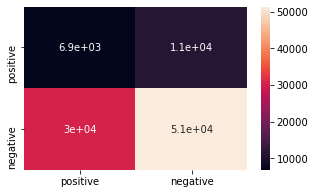

In [65]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = ['positive', 'negative'],
                  columns = ['positive', 'negative'])
plt.figure(figsize = (5,3))
sns.heatmap(df_cm, annot=True)

In [66]:
def jaccardSimilarity(s1, s2):
    s1 = set(s1)
    s2 = set(s2)
    num = len(set.intersection(s1, s2))
    denom = len(set.union(s1, s2))
    return num/denom

In [67]:
#### FOR TEST DATA 
# actual_is_duplicate = [0]*df1.count()
# row1 = df1.select('question1').collect()
# row2 = df1.select('question2').collect()
# for i in range(len(actual_is_duplicate)):
#     x = row1[i]
#     y = row2[i]
#     sim = jaccardSimilarity(x['question1'], y['question2'])
#     if(dif>0.8):
#         actual_is_duplicate[i] = 1
#     else:
#         actual_is_duplicate[i] = 0

# for i in range(len(actual_is_duplicate)):
#     actual = actual_is_duplicate[i]
#     predicted = all_cps[i]
#     if actual==predicted:
#         if actual==1:
#             tp = tp+1
#         else:
#             tn = tn+1
#     else:
#         if predicted==1:
#             fp = fp+1
#         else:
#             fn = fn+1
            
# print(tp, tn, fp, fn, len(actual_is_duplicate))

# precision = tp/(tp+fp)
# recall = tp/(tp+fn)
# accuracy = (tp+tn)/(tp+tn+fp+fn)

# print('Precision ', precision)
# print('Recall ', recall)
# print('Accuracy', accuracy)

# confusion_matrix = [[tp,fp], [fn,tn]]

# df_cm = pd.DataFrame(confusion_matrix, index = ['positive', 'negative'],
#                   columns = ['positive', 'negative'])
# plt.figure(figsize = (5,3))
# sns.heatmap(df_cm, annot=True)